In [1]:
import os
import cv2
import random
import itertools
from tqdm import *
from pathlib import Path
from natsort import natsorted
from os import makedirs, listdir
from os.path import join, exists, isdir
from PIL import Image, ImageChops, ImageEnhance
import sklearn
import numpy as np
np.random.seed(2)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.applications import (MobileNetV2, Xception, InceptionV3, EfficientNetB7, ResNet101, NASNetLarge, 
                                           VGG19, VGG16, DenseNet201)
from tensorflow.keras.applications import (mobilenet_v2, xception, inception_v3, efficientnet, resnet, nasnet, vgg19, 
                                           vgg16, densenet)
                                           

In [5]:
models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'effecientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'vgg16': VGG16,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}
preprocess = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'effecientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'vgg16': vgg16.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
    'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}

In [6]:
def compute_ela_cv(path, quality):
    # temp_filename = 'D:\College\EDI\ML\casia\CASIA1\Au\Au_ani_0001.jpg'
    image = path
    resavedfile = image.split('_')[0] + '_resaved.jpg'
    SCALE = 15
    orig_img = cv2.imread(image)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(resavedfile, orig_img, [cv2.IMWRITE_JPEG_QUALITY, 90])

    # read compressed image
    compressed_img = cv2.imread(resavedfile)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    img_diff = Image.fromarray(diff)
    img_diff
    return img_diff    
    
    
    
    

In [7]:
def compute_hsvela_cv(path, quality):
    # temp_filename = 'D:\College\EDI\ML\casia\CASIA1\Au\Au_ani_0001.jpg'
    image = path
    hsvimage = image.split('_')[0] + '_hsv.jpg'
    resavedfile = image.split('_')[0] + '_resaved.jpg'
    SCALE = 15
    hsv_image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2HSV)
    cv2.imwrite(hsvimage, hsv_image)
    orig_img = cv2.imread(hsvimage)

    cv2.imwrite(resavedfile, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(resavedfile)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    img_diff = Image.fromarray(diff)
    img_diff
    return img_diff

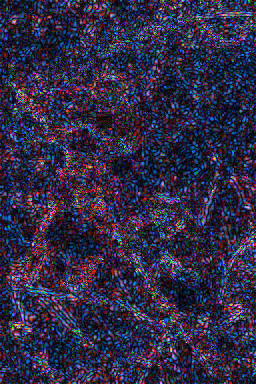

In [8]:
compute_hsvela_cv("D:\College\EDI\monkey-1.jpg", 90)

In [9]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

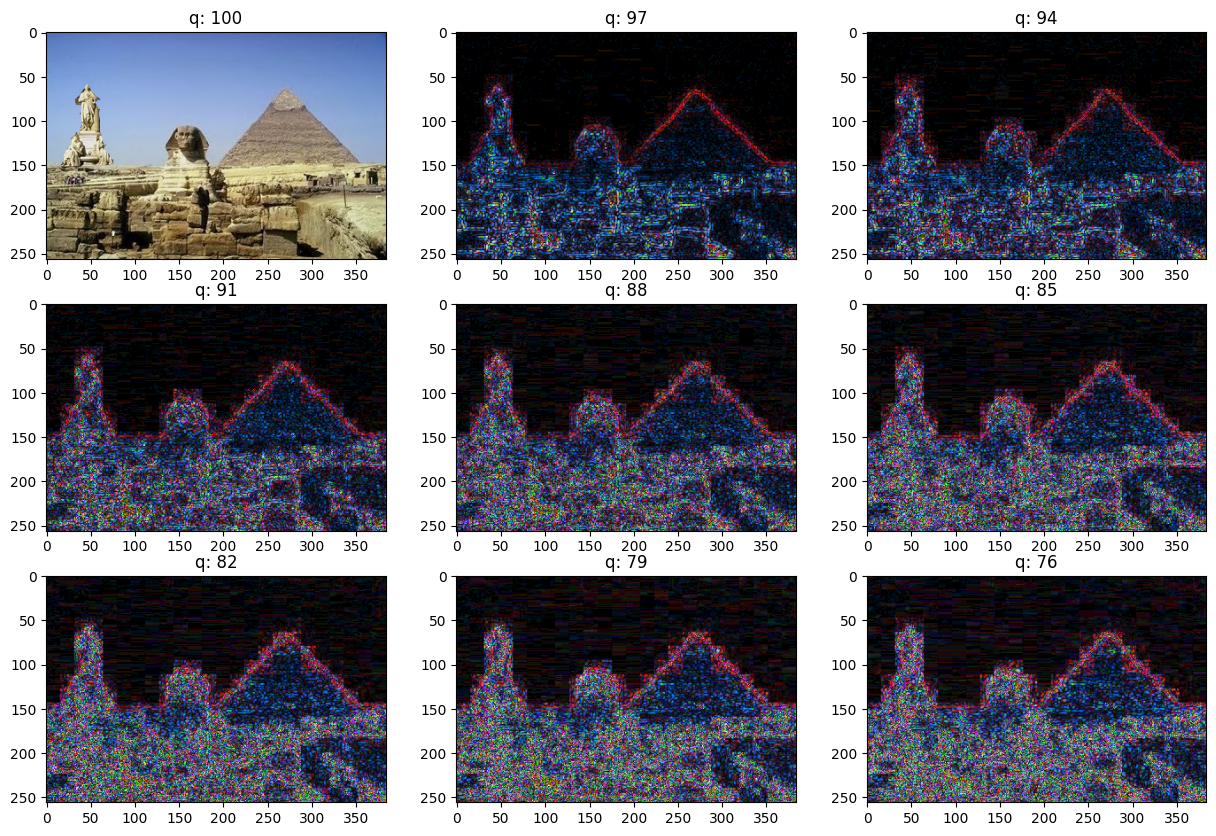

In [42]:
p = random_sample('D:/College/EDI/ML/casia/CASIA1/Sp/')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_hsvela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

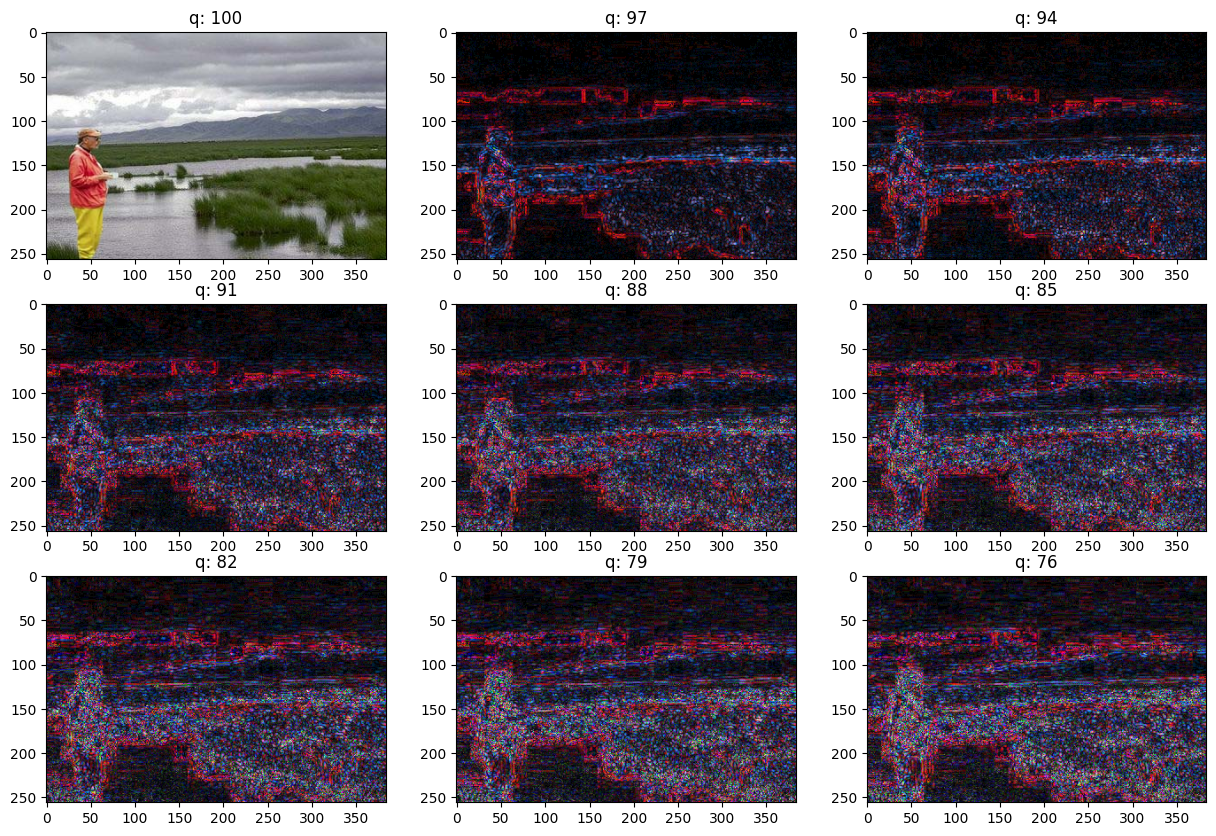

In [39]:
p = random_sample('D:/College/EDI/ML/casia/CASIA1/Sp/')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_hsvela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()## Test on a spliced fake image

In [19]:
@tf.function
def tensor_aug(img):
    img = tf.image.random_flip_left_right(img, 5)
    img = tf.image.random_flip_up_down(img, 5)
    return img

@tf.function
def batch_aug(images, labels):
    images = tf.map_fn(lambda img: tensor_aug(img), images)
    return images, labels

In [20]:
def ela_process(file_path):
    # https://www.tensorflow.org/guide/data
    QUALITY = 95
    SCALE = 15
    LABELS = np.array(['Au', 'Tp'])
    
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == LABELS
    # Integer encode the label
    label = tf.argmax(one_hot)
    label = tf.cast(label, tf.float32)
     # Generate the image
    orig = cv2.imread(file_path.numpy().decode('utf-8'))
    orig = cv2.resize(orig, (224, 224), interpolation = cv2.INTER_AREA)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    # Augmentation
#     orig = albumentation_aug(orig)
    # Save it in buffer
    _, buffer = cv2.imencode(".jpg", orig, [cv2.IMWRITE_JPEG_QUALITY, QUALITY])
    # get it from buffer and decode it to numpy array
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)
      # Compute the absolute difference
    diff = SCALE * (cv2.absdiff(orig, compressed_img))
    img = preprocess['xception'](diff)
    
    return img, label

In [21]:
jpg_pattern = 'C:/Users/arnav/Desktop/ml/casia/CASIA2/*/*jp*g'
tif_pattern = 'C:/Users/arnav/Desktop/ml/casia/CASIA2/*/*tif'

jpg_files = tf.data.Dataset.list_files(tif_pattern)
tif_files = tf.data.Dataset.list_files(jpg_pattern)

data_ds = jpg_files.concatenate(tif_files)

tensor_preprocess = lambda x: tf.py_function(ela_process, [x], [tf.float32, tf.float32])
n_data = data_ds.cardinality().numpy()
n_val = int(.2 * n_data)
data_ds = data_ds.shuffle(n_data)

train_ds = data_ds.skip(n_val).map(
    tensor_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).map(
    batch_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_ds = data_ds.take(n_val).map(
    tensor_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

for img, label in train_ds:
    print(label)
    break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
tf.Tensor(
[1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1.], shape=(32,), dtype=float32)


In [22]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [23]:
def create_model(optimizer, name='mobilenet', loss='categorical_crossentropy'):
    """
    Creates model based on the input name and freezes `blocks_to_train` blocks.
    Args: 
        optimizer(tf.keras.optimizers): initialized tensorflow optimizers.
        name(str): one of the keys in the `models` list.
        blocks_to_train: name of the blocks to freeze, if not given all the 
        layers will be trainable.
        loss: sets loss
        
    """
    base_model = models[name](include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # model = Model(base_model.inputs, base_model.layers[-1].output)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.inputs, output)
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

In [24]:
def scheduler(epoch):
    if epoch % 25 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.9)
        
    return K.get_value(model.optimizer.lr)

def generate_path(path_to_output, last_run=False):
    """
    Creates new path and returns the address.
    Notes:
        Sometimes accidently it happens that you overwrite your previous models. so
        this function is designed to create a new path for each run.
    """
    if not isdir(path_to_output):
        makedirs(path_to_output)
    
    runs = natsorted([path for path in listdir(path_to_output) if path.startswith("run_tf_data")])
    if last_run:
        if not bool(runs):
            path = os.path.join(path_to_output, "run_tf_data_1")
        else:
            path = os.path.join(path_to_output, runs[-1])

        return path
    if not bool(runs):
        path = os.path.join(path_to_output, 'run_tf_data_1')
    else:
        f = runs[-1].rsplit("data_")[1]
        path = os.path.join(path_to_output, 'run_tf_data_' + str(int(f) + 1))
        
    return path

In [25]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = SGD(learning_rate=1e-3, 
#                 decay=1e-6, 
                momentum=0.95, 
                nesterov=False)
                
model = create_model(optimizer, name='xception', loss=loss)

83683744/83683744 [==============================] - 49s 1us/step


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [27]:
path = generate_path('checkpoints')
weight_path = os.path.join(path, 'weights')
tensorboard_path = os.path.join(path, 'logs')

makedirs(weight_path)
makedirs(tensorboard_path)

ckpt = ModelCheckpoint(
    filepath=weight_path, 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=True
)
tensorboard = TensorBoard(
    log_dir=tensorboard_path, 
    write_graph=True
)

reduce_lr = LearningRateScheduler(scheduler)


callbacks = [ckpt, 
#              reduce_lr, 
             tensorboard]

In [29]:
history = model.fit(
    train_ds,
    epochs=6,
    batch_size=32,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/6
315/315 [==============================] - 1980s 6s/step - loss: 0.4878 - accuracy: 0.0603 - precision: 0.7661 - recall: 0.6195 - auc: 0.8450 - prc: 0.7785 - val_loss: 0.3389 - val_accuracy: 0.0506 - val_precision: 0.8583 - val_recall: 0.7562 - val_auc: 0.9312 - val_prc: 0.9021
Epoch 2/6
315/315 [==============================] - 2010s 6s/step - loss: 0.3175 - accuracy: 0.0698 - precision: 0.8202 - recall: 0.8507 - auc: 0.9349 - prc: 0.9045 - val_loss: 0.2167 - val_accuracy: 0.0633 - val_precision: 0.8761 - val_recall: 0.8761 - val_auc: 0.9704 - val_prc: 0.9559
Epoch 3/6
315/315 [==============================] - 2006s 6s/step - loss: 0.2482 - accuracy: 0.0698 - precision: 0.8466 - recall: 0.8925 - auc: 0.9600 - prc: 0.9419 - val_loss: 0.1764 - val_accuracy: 0.1013 - val_precision: 0.8917 - val_recall: 0.9378 - val_auc: 0.9808 - val_prc: 0.9704
Epoch 4/6
315/315 [==============================] - 1994s 6s/step - loss: 0.2095 - accuracy: 0.0730 - precision: 0.8662 - recall: 0.

In [31]:
model.save("pic1.h5")

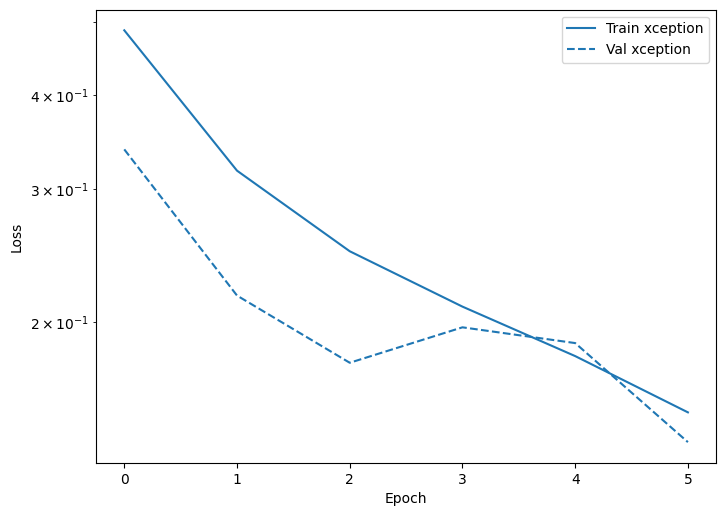

In [32]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# Plot loss

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, 'xception', 0)

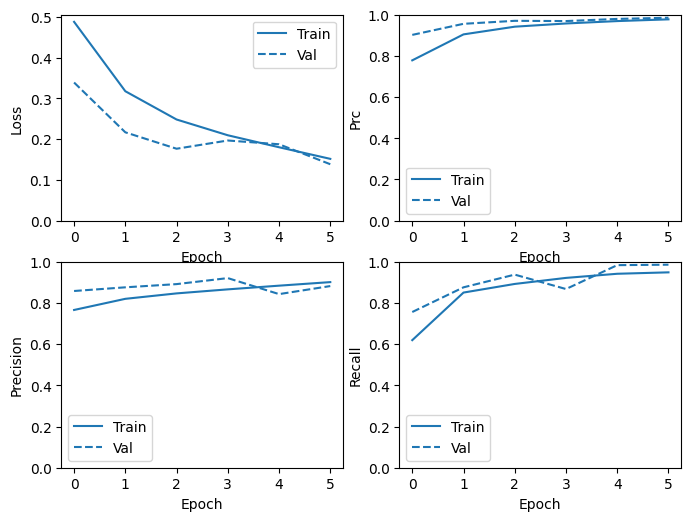

In [33]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [34]:
val_ds_x = []
val_ds_y = []

for _, (val_x_batch, val_y_batch) in enumerate(val_ds):
    for val_x, val_y in zip(val_x_batch, val_y_batch):
        val_ds_x.append(val_x)
        val_ds_y.append(val_y)

val_data = (tf.convert_to_tensor(val_ds_x, dtype=tf.float32), 
            tf.convert_to_tensor(val_ds_y, dtype=tf.float32))

val_data[0].numpy().shape

(2512, 224, 224, 3)

79/79 [==============================] - 136s 2s/step
loss :  0.12032179534435272
accuracy :  0.037974681705236435
precision :  0.9032830595970154
recall :  0.9902724027633667
auc :  0.9933873414993286
prc :  0.9900371432304382



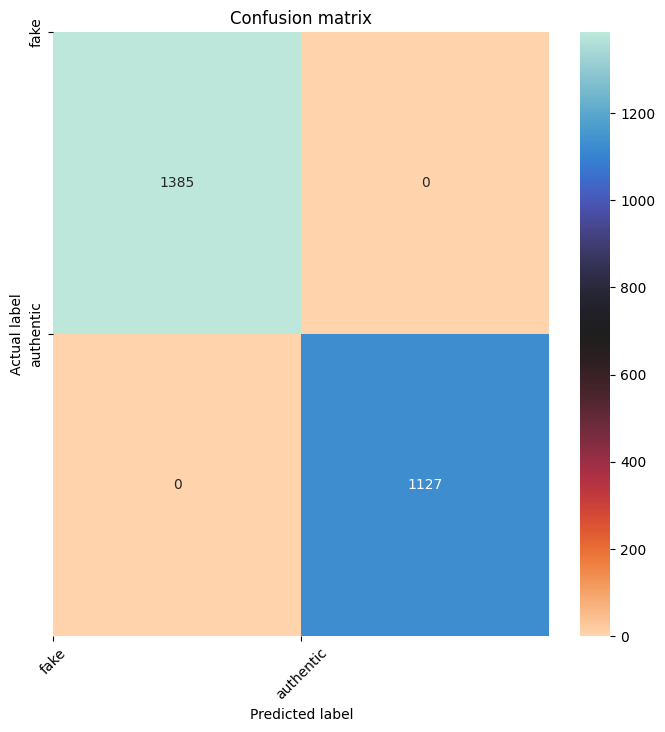

In [36]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# sns.color_palette("mako", as_cmap=True)
class_names = ['fake', 'authentic'] # make sure its correct

test_predictions_baseline = model.predict(val_data[0].numpy(), batch_size=32)
## CHECK
def plot_cm(label_matrix, predictions):
    
    preds = np.around(np.squeeze(predictions))
    gt = np.around(np.squeeze(predictions))
    
    cm = confusion_matrix(gt, 
                          preds,
                          labels=np.array([0, 1]))
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="icefire_r")
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

baseline_results = model.evaluate(val_data[0].numpy(), 
                                  val_data[1].numpy(),
                                  batch_size=32, 
                                  verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(val_data[1].numpy(), np.squeeze(test_predictions_baseline))